In [1]:
%load_ext autoreload
%autoreload 2
%cd ../..

/gpfs/home/vhl2022/projects/rcpp


length:  523
Rate of positive labels in training set = 0.5000.
PDF upper bound = 2.243903982547501.
Cp = 1.1220.


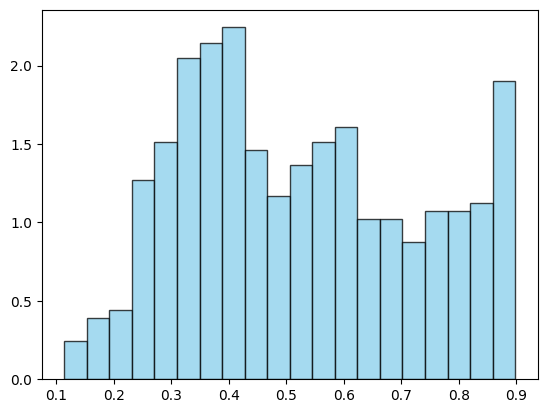

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

from rcpp.width_calculator import CLTWidth
from rcpp.risk_measure import MeanRiskMeasure
from rcpp.loss_simulator import ZeroOneLossSimulator

from applications.credit_scoring.utils import (
    load_data,
    create_balanced_split,
    CreditScoringSimulator,
    run_credit_experiment,
    run_trajectory
)


class Args:
    def __init__(self):
        self.alpha = 0.3         # risk control level
        self.tightness = 0.08    # tightness parameter, may throw error if too low
        self.delta = 0.1        # failure probability or confidence parameter
        self.tau = 1.0           # safety parameter
        self.N = 2000            # number of samples in cohort
        self.lambda_min = 0.1
        self.lambda_safe = 1.0    # maximum value for lambda
        self.ell_max = 1.0
        self.gamma = 1.0         # parameter in the Wasserstein distance formulation, for simulating distribution shift
        self.shift_size = 0.3

args = Args()

np.random.seed(42)

# Load data
path_to_csv_file = './applications/credit_scoring/data/cs-training.csv'
X_all, Y_all = load_data(path_to_csv_file)  # Shape (N, 11), (N,)

# Train model
X_train, Y_train, X_temp, Y_temp = create_balanced_split(X_all, Y_all, num_balanced_samples=1500, class1_proportion=0.5)
model = LogisticRegression(fit_intercept=False)
model.fit(X_train, Y_train)
Y_hat = model.predict_proba(X_train)[:,1]
Y_hat = Y_hat[(Y_train == 1) & (Y_hat < 1 - args.lambda_min)]
print("length: ", len(Y_hat))
counts, bins, _ = plt.hist(Y_hat, bins=20, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')
M = counts.max() # PDF upper bound
print(f"Rate of positive labels in training set = {Y_train.mean():.4f}.")
print(f"PDF upper bound = {M}.")
Cp = Y_train.mean() * M
print(f"Cp = {Cp:.4f}.")
del X_train, Y_train

# Generate PRC data
idx_1 = np.where(Y_temp == 1)[0]
idx_0 = np.where(Y_temp == 0)[0][:10000]
indices = np.concatenate((idx_1, idx_0))
X = X_temp[indices]
Y_hat = model.predict_proba(X)[:,1]
Y = Y_temp[indices]
del idx_1, idx_0, indices, X, X_temp, Y_temp

# Run experiment
width_calculator = CLTWidth(args.alpha, args.ell_max, tol=1e-5)
risk_measure = MeanRiskMeasure()
performativity_simulator = CreditScoringSimulator(shift_size=args.shift_size)
loss_simulator = ZeroOneLossSimulator()

from copy import deepcopy

def run_credit_experiment(
    Z,
    width_calculator,
    risk_measure,
    performativity_simulator,
    loss_simulator,
    args,
    taus = [1e-3, 1e-1, 1, 10, 1e2],
    save_dir: str = "./figures",
    num_iters: int = 1000,
):
    """
    Run the RCPP algorithm and plot the results.
    """

    def cut(data):
        tot = len(data[0])
        assert tot > args.N
        idx = np.random.choice(tot, size=args.N, replace=False)
        data_cal = [d[idx] for d in data]
        data_test = [d[~idx] for d in data]
        return data_cal, data_test
    
    tau_trajectories = []
    for tau in taus:
        args_copy = deepcopy(args)
        args_copy.tau = tau
        Z_cal, Z_test = cut(Z)
        trajectories = []
        for _ in range(num_iters):
            trajectory = run_trajectory(
                Z_cal,
                Z_test,
                width_calculator,
                risk_measure,
                performativity_simulator,
                loss_simulator,
                args_copy
            )
            trajectories.append(trajectory)
        tau_trajectories.append(trajectories)

    return tau_trajectories


save_dir = "./applications/credit_scoring/figures/expected_loss/"
taus = [1e-3, 1e-1, 2e-1, 5e-1, 8e-1, 1, 2]

tau_trajectories = run_credit_experiment(
    Z=[Y_hat, Y],
    width_calculator=width_calculator,
    risk_measure=risk_measure,
    performativity_simulator=performativity_simulator,
    loss_simulator=loss_simulator,
    args=args,
    taus=taus,
    # save_dir="./applications/credit_scoring/figures/expected_loss/",
    num_iters=5
)


In [3]:
import os

Guaranteed convergence by T=704
Saved lambda plot to ./applications/credit_scoring/figures/expected_loss/lambda_vs_iteration.pdf
Saved lambda plot to ./applications/credit_scoring/figures/expected_loss/lambda_diff_vs_iteration.pdf


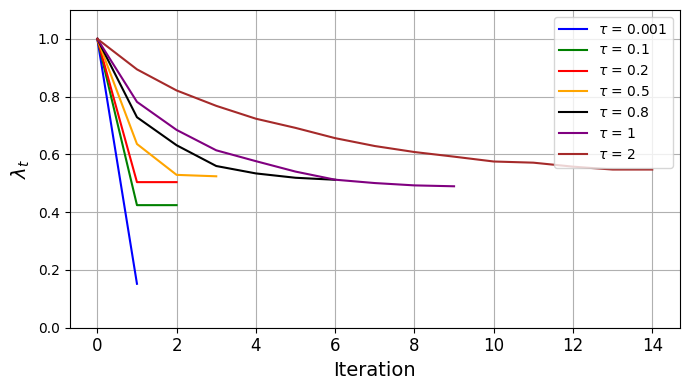

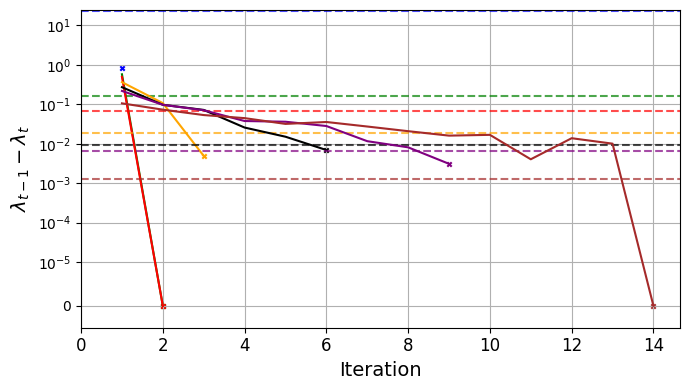

In [4]:
trajectories = tau_trajectories

plt.figure(figsize=(7, 4))
plt.ylim(0, args.lambda_safe)
colors = ['blue', 'green', 'red', 'orange', 'black', 'purple', 'brown']
max_iters = 0
for i in range(len(trajectories)):
    for j in range(len(trajectories[i])):
        label = rf"$\tau$ = {taus[i]}" if len(taus) > 1 and j == 0 else None
        plt.plot(trajectories[i][j].lambdas, label=label, color=colors[i], alpha=min(1, 10 / len(trajectories[i])))
        max_iters = max(max_iters, len(trajectories[i][j].lambdas))
        break
plt.xlabel('Iteration', fontsize=14)
plt.ylabel(r'$\lambda_t$', fontsize=14)
plt.xticks(ticks=range(0, max_iters + 1, 2), labels=[str(i) for i in range(0, max_iters + 1, 2)], fontsize=12)
plt.ylim(0, 1.1)
print(f"Guaranteed convergence by T={trajectories[i][0].guaranteed_T}")
leg = plt.legend(loc='upper right')
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.grid(True)
plt.tight_layout()
if save_dir:
    save_path = os.path.join(save_dir, "lambda_vs_iteration.pdf")
    plt.savefig(save_path, dpi=300)
    print(f"Saved lambda plot to {save_path}")

plt.figure(figsize=(7, 4))
max_iters = 0
for i in range(len(trajectories)):
    last_diffs = []  # for scatter plot
    for j in range(len(trajectories[i])):
        label = rf"$\tau$ = {taus[i]}" if len(taus) > 1 and j == 0 else None
        diffs = np.abs(trajectories[i][j].lambdas[1:] - trajectories[i][j].lambdas[:-1])
        # diffs = np.clip(diffs, 1e-5, np.inf)
        max_iters = max(max_iters, len(diffs))
        plt.plot(range(1, len(diffs) + 1), diffs, markersize=2,
                label=label, color=colors[i], alpha=min(1, 10 / len(trajectories[i])))
        if len(diffs) > 0:
            last_diffs.append((len(diffs), diffs[-1]))
        break
    

    if last_diffs:
        plt.scatter(*zip(*last_diffs), color=colors[i], s=10, alpha=min(1, 10 / len(trajectories[i])), marker='x')

    plt.axhline(y=trajectories[i][0].delta_lambda, color=colors[i], linestyle='--', linewidth=1.5, alpha=0.7)

# `delta_lambda` is the same for all taus
plt.xlabel('Iteration', fontsize=14)
plt.xticks(ticks=range(0, max_iters + 1, 2), labels=[str(i) for i in range(0, max_iters + 1, 2)], fontsize=12)
plt.ylabel(r'$\lambda_{t-1} - \lambda_t$', fontsize=14)
plt.yscale('symlog', linthresh=1e-5)
plt.ylim(bottom=-5e-6)
plt.grid(True)
plt.tight_layout()
if save_dir:
    save_path = os.path.join(save_dir, "lambda_diff_vs_iteration.pdf")
    plt.savefig(save_path, dpi=300)
    print(f"Saved lambda plot to {save_path}")

Saved loss plot to ./applications/credit_scoring/figures/expected_loss/loss_vs_iteration.pdf


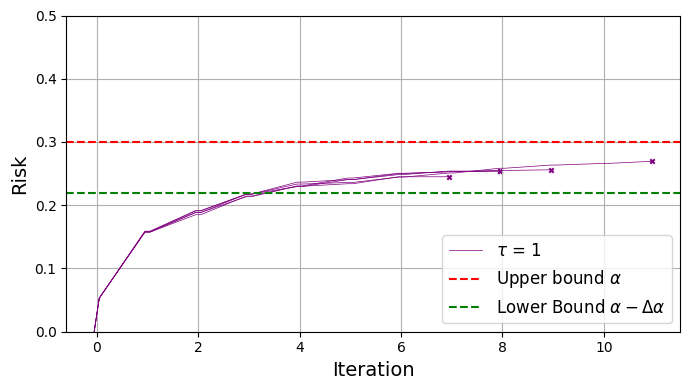

In [43]:
idx = -2
trajectories = tau_trajectories[idx]

# Each of these arrays is of length 2 * max_t + 1
# It contains max_t pairs of L(lambda_t, lambda_t) and L(lambda_{t-1}, lambda_t) in that order
risk_mean = []
trajectories_remaining = []

plt.figure(figsize=(7, 4))

offset = 0.05
endpoints = []
num_trajectories = len(trajectories)  #3  #len(trajectories)
for i in range(num_trajectories):
    xs, risks = [], []
    trajectory = trajectories[i]
    assert len(trajectory.risks_tt) == len(trajectory.risks_tm1_t) + 1
    for j in range(len(trajectory.risks_tt)):
        xs.append(j - offset)
        risks.append(trajectory.risks_tt[j])
        if j < len(trajectory.risks_tm1_t):
            xs.append(j + offset)
            risks.append(trajectory.risks_tm1_t[j])
        else:
            endpoints.append((j - offset, trajectory.risks_tt[j]))
    label = rf"$\tau$ = {taus[idx]}" if len(taus) > 1 and i == 0 else None
    plt.plot(xs, risks, color=colors[idx], alpha=min(1, 10. / num_trajectories), linewidth=0.5, label=label)
plt.scatter(*zip(*endpoints), color=colors[idx], s=10, alpha=min(1, 10. / num_trajectories), marker='x')

plt.axhline(args.alpha, linestyle='--', color='red', label=r'Upper bound $\alpha$')
plt.axhline(args.alpha - args.tightness, linestyle='--', color='green', label=r'Lower Bound $\alpha - \Delta\alpha$')

plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Risk", fontsize=14)
plt.ylim(0, 0.5)
plt.legend(fontsize=12, loc='lower right')
for lh in plt.gca().get_legend().legend_handles:
    lh.set_alpha(1)
plt.grid(True)
plt.tight_layout()
if save_dir:
    save_path = os.path.join(save_dir, "loss_vs_iteration.pdf")
    plt.savefig(save_path, dpi=300)
    print(f"Saved loss plot to {save_path}")

Saved final loss plot to ./applications/credit_scoring/figures/expected_loss/final_loss_vs_tau.pdf


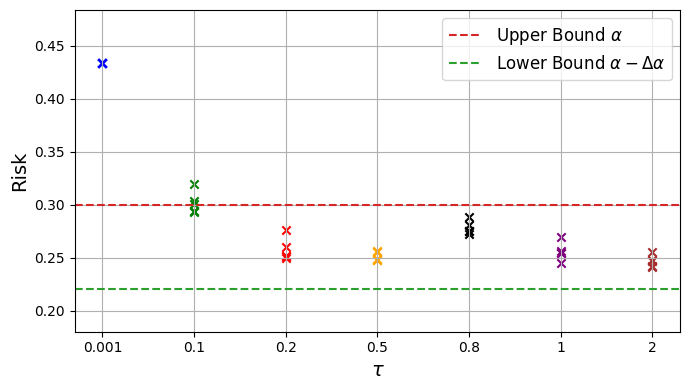

In [44]:
if save_dir:
    os.makedirs(save_dir, exist_ok=True)

end_risks = []
for trajectories in tau_trajectories:
    end_risks_tau = []
    for trajectory in trajectories:
        end_risks_tau.append(trajectory.risks_tt[-1])
    end_risks.append(end_risks_tau)

x_indices = np.arange(len(taus))

plt.figure(figsize=(7, 4))

for i, index in enumerate(x_indices):
    y_values = end_risks[i]
    x_values = [index] * len(y_values)  # Repeat index for each end_risk value
    plt.scatter(x_values, y_values, marker='x', color=colors[i], alpha=min(1, 10. / len(trajectories)))
plt.xticks(x_indices, taus)
plt.axhline(args.alpha, linestyle='--', color='#d62728', label=r'Upper Bound $\alpha$', linewidth=1.5)  # red
plt.axhline(args.alpha - args.tightness, linestyle='--', color='#2ca02c', label=r'Lower Bound $\alpha - \Delta\alpha$', linewidth=1.5)  # green

plt.xlabel(rf"$\tau$", fontsize=14)
plt.ylabel("Risk", fontsize=14)

ylim_lower = min(0.05 + min([min(risks) for risks in end_risks]), args.alpha - args.tightness * 1.5)
ylim_upper = max(0.05 + max([max(risks) for risks in end_risks]), args.alpha + args.tightness * 0.5)
plt.ylim(ylim_lower, ylim_upper)

plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

if save_dir:
    save_path = os.path.join(save_dir, "final_loss_vs_tau.pdf")
    plt.savefig(save_path, dpi=300)
    print(f"Saved final loss plot to {save_path}")

In [45]:
in_bounds = []
out_of_bounds = []
for end_risks_tau in end_risks:
    in_bounds.append(0)
    out_of_bounds.append(0)
    for end_risk in end_risks_tau:
        if args.alpha - args.tightness <= end_risk <= args.alpha:
            in_bounds[-1] += 1
        else:
            out_of_bounds[-1] += 1

Saved final loss plot to ./applications/credit_scoring/figures/expected_loss/failure_prob_vs_tau.pdf


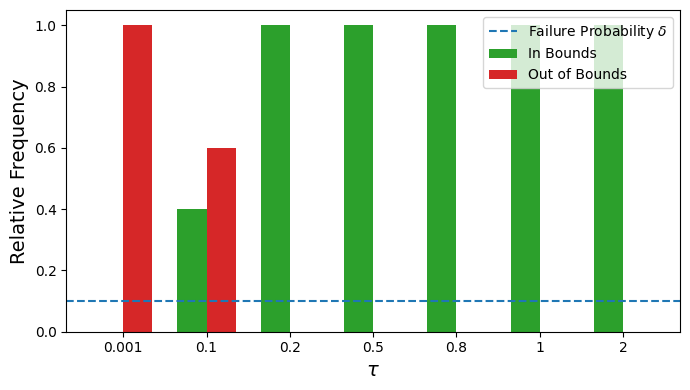

In [46]:
total = [i + o for i, o in zip(in_bounds, out_of_bounds)]
in_bounds_frac = [i / t if t > 0 else 0 for i, t in zip(in_bounds, total)]
out_of_bounds_frac = [o / t if t > 0 else 0 for o, t in zip(out_of_bounds, total)]

n_groups = len(taus)

fig, ax = plt.subplots(figsize=(7, 4))

bar_width = 0.35
index = np.arange(n_groups)

# Plot bars
rects1 = ax.bar(index, in_bounds_frac, bar_width,
                label='In Bounds', color='#2ca02c')

rects2 = ax.bar(index + bar_width, out_of_bounds_frac, bar_width,
                label='Out of Bounds', color='#d62728')

ax.axhline(args.delta, linestyle='--', color='#1f77b4', label=r'Failure Probability $\delta$', linewidth=1.5)

# Add labels, title, and ticks
ax.set_xlabel(rf"$\tau$", fontsize=14)
ax.set_ylabel('Relative Frequency', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(taus)
ax.legend()


plt.tight_layout()
if save_dir:
    save_path = os.path.join(save_dir, "failure_prob_vs_tau.pdf")
    plt.savefig(save_path, dpi=300)
    print(f"Saved final loss plot to {save_path}")